In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import datetime as dt
import os
import re
import pandas as pd
import random as rd
import numba
os.chdir('k:/a')

In [2]:
global gradientcolor

In [3]:
gradientcolor=['#cfcaca',
 '#cec9c9',
 '#cdc8c8',
 '#ccc7c7',
 '#cbc7c6',
 '#cac6c5',
 '#c9c5c4',
 '#c8c4c3',
 '#c7c3c3',
 '#c6c2c2',
 '#c5c1c1',
 '#c4c0c0',
 '#c3c0bf',
 '#c2bfbe',
 '#c1bebd',
 '#c0bdbc',
 '#c0bcbb',
 '#bfbbba',
 '#bebab9',
 '#bdb9b8',
 '#bcb9b7',
 '#bbb8b6',
 '#bab7b5',
 '#b9b6b4',
 '#b8b5b4',
 '#b7b4b3',
 '#b6b3b2',
 '#b5b2b1',
 '#b4b2b0',
 '#b3b1af',
 '#b2b0ae',
 '#b1afad',
 '#b0aeac',
 '#afadab',
 '#adaca9',
 '#acaaa8',
 '#aba9a7',
 '#aaa8a6',
 '#a9a7a5',
 '#a7a6a3',
 '#a6a5a2',
 '#a5a4a1',
 '#a4a3a0',
 '#a3a19f',
 '#a1a09d',
 '#a09f9c',
 '#9f9e9b',
 '#9e9d9a',
 '#9d9c99',
 '#9c9b98',
 '#9a9a96',
 '#999895',
 '#989794',
 '#979693',
 '#969592',
 '#949490',
 '#93938f',
 '#92928e',
 '#91918d',
 '#908f8c',
 '#8e8e8a',
 '#8d8d89',
 '#8c8c88',
 '#8a8a86',
 '#888884',
 '#858582',
 '#838380',
 '#81817d',
 '#7f7f7b',
 '#7c7c79',
 '#7a7a77',
 '#787875',
 '#767673',
 '#737471',
 '#71716f',
 '#6f6f6c',
 '#6d6d6a',
 '#6a6b68',
 '#686966',
 '#666664',
 '#646462',
 '#616260',
 '#5f605e',
 '#5d5d5b',
 '#5b5b59',
 '#585957',
 '#565755',
 '#545553',
 '#525251',
 '#4f504f',
 '#4d4e4d',
 '#4b4c4a',
 '#494948',
 '#464746',
 '#444544',
 '#434443',
 '#414241',
 '#404140',
 '#3f403f',
 '#3e3f3e',
 '#3c3d3c',
 '#3b3c3b',
 '#3a3b3a',
 '#393939',
 '#373837',
 '#363736',
 '#353635',
 '#343434',
 '#323332',
 '#313231',
 '#303030',
 '#2f2f2f',
 '#2d2e2d',
 '#2c2c2c',
 '#2b2b2b',
 '#2a2a2a',
 '#282928',
 '#272727',
 '#262626',
 '#252525',
 '#232323',
 '#222222',
 '#212121',
 '#202020',
 '#1e1e1e',
 '#1d1d1d',
 '#1c1c1c',
 '#1c1c1c',
]

In [4]:
global dailycontactmin,dailycontactmax

In [5]:
dailycontactmin,dailycontactmax=60.,1000.

In [6]:
#get demographic data
def get_demographic(un_total,un_birth,un_death,country,year):
    
    #the unit is in '000
    population=un_total['Value'][un_total['Country or Area']==country][un_total['Year(s)']==year][un_total['Variant']=='Medium'].item()*1000
    population0=un_total['Value'][un_total['Country or Area']==country][un_total['Year(s)']==(year-1)][un_total['Variant']=='Medium'].item()*1000
    
    #for some reason, un doesnt provide crude rate per year, only annual rate per 5 year
    yearrange='%s-%s'%(2000+(year-2000)//5*5,2005+(year-2000)//5*5)
    
    #crude birth and death rate per 1000 people
    birth=un_birth['Value'][un_birth['Country or Area']==country][un_birth['Year(s)']==yearrange][un_birth['Variant']=='Medium'].item()/1000
    death=un_death['Value'][un_death['Country or Area']==country][un_death['Year(s)']==yearrange][un_death['Variant']=='Medium'].item()/1000
    
    #avoid python float error
    birth=round(birth,6)
    death=round(death,6)
    population=round(population,0)
    population0=round(population0,0)
    
    return (birth,death,population,population0)

In [7]:
#cleansing data
def prepare_data(df,demographic,country):
    
    birth,death,population,population0=demographic
    
    data=df.loc[df['Number recovered'][df['Country']==country].dropna().index]
    data.set_index('report date',inplace=True)
    data.index=pd.to_datetime(data.index)

    #Number recovered denotes R in the dynamic system
    #Number of deaths denotes D in the dynamic system
    data=data[['Number recovered','Number of deaths','Cumulative number of cases']].copy(deep=True)

    #currently infected denotes I in the dynamic system
    data['currently infected']=data['Cumulative number of cases']-data['Number recovered']-data['Number of deaths']

    #time denotes t in the dynamic system
    dif=pd.Series(data.index).diff()
    data['time']=dif.fillna('0').apply(lambda x: re.findall('\d+',str(x))[0]).astype(int).cumsum().tolist()

    #the tricky part is the susceptible
    #it is the total population minus cumulated cases
    #and the total population should also include natural birth and death

    #first we need to convert annual rate to daily rate as we got daily data
    birthdaily=(birth+1)**(1/365)-1

    #the case of daily death rate is slightly more complicated
    #we need to exclude virus caused fatality
    #the revised rate is a tiny change in the decimals
    death_nonvirus=round((death*population),0)-df['Number of deaths'][df['Country']==country][pd.to_datetime(df['report date'])<'2004-01-01'].iloc[-1]
    realdeath=death_nonvirus/population
    deathdaily=(realdeath+1)**(1/365)-1

    #the daily population projection excludes immigration and emigration
    #first, its challenging to find daily immigration and emigration data
    #i am pretty sure the government has it but i cannot find it for free
    #second, when the quarantines kicked in, no flights were allowed
    #many places in asia became a closed system
    ppl=pd.DataFrame()
    ppl['population']=[round(population0*((1+birthdaily-deathdaily)**i),0) for i in range(365)]
    ppl['report date']=[pd.to_datetime('2003-01-01')+dt.timedelta(days=i) for i in range(365)]
    ppl.set_index('report date',inplace=True)
    
    #merge
    data=data.merge(ppl,left_index=True,right_index=True)

    #not needed in barabási-albert model
    data['random graph probability']=0.0
    
    #susceptible denotes S in the dynamic system
    data['susceptible']=data['population']-data['Cumulative number of cases']
    
    data['theta']=genr_THETA(data['population'].tolist(),
                             data['susceptible'].tolist(),
                             rand_prob=data['random graph probability'].iloc[0])
    
    data['alpha']=birthdaily
    data['gamma']=deathdaily
    data['country']=country
    
    return data

In [8]:
#assume this is a barabási-albert graph
@numba.jit(nopython=True)
def prob_genr_func(z,N,rand_prob=0.02):
    
    kmin=dailycontactmin
    kmax=dailycontactmax
    
    degreelist=np.arange(kmin,kmax)
    thetalist=np.array([float(z)]*int(kmax-kmin))

    denominator=np.power(degreelist,3)    
    
    numerator_constant=2*kmin*(kmin+1)
    numerator_power=np.power(thetalist,np.arange(1,kmax-kmin+1))
    numerator=np.multiply(numerator_constant,numerator_power)
    
    
    return np.divide(numerator,denominator).sum()


@numba.jit(nopython=True)
def prob_genr_func_1st_dvt(z,N,rand_prob=0.02):
    
    kmin=dailycontactmin
    kmax=dailycontactmax
    
    degreelist=np.arange(kmin,kmax)
    denominator=np.power(degreelist,2)
    
    #efficiency
    if z==1:
        numerator=np.array([2*kmin*(kmin+1)]*int(kmax-kmin))
    else:        
        thetalist=np.array([float(z)]*int(kmax-kmin))        
        numerator_constant=2*kmin*(kmin+1)
        numerator_power=np.power(thetalist,np.arange(0,kmax-kmin))
        numerator=np.multiply(numerator_constant,numerator_power)  
    
    return np.divide(numerator,denominator).sum()


@numba.jit(nopython=True)
def prob_genr_func_2nd_dvt(z,N,rand_prob=0.02):  
    
    kmin=dailycontactmin
    kmax=dailycontactmax
    
    degreelist=np.arange(kmin,kmax)
    denominator=np.power(degreelist,2)
    
    #efficiency
    if z==1:
        numerator=np.array([2*kmin*(kmin+1)*(k-1) for k in degreelist])
    else:        
        thetalist=np.array([float(z)]*int(kmax-kmin))        
        numerator_constant=np.array([2*kmin*(kmin+1)*(k-1) for k in degreelist])
        numerator_power=np.power(thetalist,np.arange(-1,kmax-kmin-1))
        numerator=np.multiply(numerator_constant,numerator_power)  
    
    return np.divide(numerator,denominator).sum()

In [9]:
#generate S from probability generation function
@numba.jit(nopython=True)
def genr_S(N,THETA,rand_prob=0.02):
    
    S=[]
    
    for i in range(len(N)):
        S.append(N[i]*prob_genr_func(THETA[i],N[i],rand_prob=rand_prob))
    
    return S

In [10]:
#treat probability generating function as polynomial equation
#where probability is constant cuz we can compute them from power law
#theta becomes the unknown, the roots of polynomial equation
#this function prepares coefficients for polynomial equation
@numba.jit(nopython=True)
def poly_coeffs(N,S):
    
    kmax=dailycontactmax
    kmin=dailycontactmin
    
    degreelist=np.arange(kmin,kmax)
    denominator=np.power(degreelist,3)
    
    numerator=2*kmin*(kmin+1)
    
    param=np.divide(numerator,denominator)    
    coeff=np.array(list(param[::-1])+[-S/N])
    
    return coeff

@numba.jit(nopython=True)
def get_solution(root):    
    return [i.real for i in root if i.imag==0 and i.real>0]

#numba doesnt support domain change from real to complex
#our polynomial equation has a lot of complex roots
#due to its order of power
#unfortunately we will have to live with the slow performance
def genr_THETA(N,S,rand_prob=0.02):
    
    THETA=[]
    for ind in range(len(N)):
        coeff=poly_coeffs(N[ind],S[ind])
        root=np.roots(coeff)
        solution=get_solution(root)
        THETA+=solution
        
    return THETA

In [11]:
#modified version of sir model with vital dynamics
#include natural birth, natural death and virus death
@numba.jit(nopython=True)
def EB_SIRmodel(z,t,known,unknown):
    
    N,I,rand_prob=known
    beta,delta,epsilon=unknown
    
    THETA=z[0]
    R=z[1]
    D=z[2]
    
    #edge based model requires fewer equations than degree based or pairwise
    dTHETAdt=-beta+beta*prob_genr_func_1st_dvt(THETA,N,rand_prob=rand_prob)/prob_genr_func_1st_dvt(1,N,rand_prob=rand_prob)+(epsilon+delta)*(1-THETA)
    dRdt=epsilon*I
    dDdt=delta*I
    
    dzdt=[dTHETAdt,dRdt,dDdt]
    
    return dzdt

In [12]:
#put all differential equations together
def dynamicsystem(unknown):
    
    t=data['time'].tolist()
        
    #create a list to store fitted values
    fitted=np.zeros((len(t),3))
    
    #initial value
    fitted[0,0]=data['theta'].iloc[0]
    fitted[0,1]=data['Number recovered'].iloc[0]
    fitted[0,2]=data['Number of deaths'].iloc[0]
    
    z0=fitted[0]
    
    #we compute the fitted value via iterations
    #becuz this way is compatible with non-linear least square
    for i in range(1,len(t)):
        
        #no report on sunday
        #i suppose WHO staff go to church as well
        #no, i am kidding, they deserve a break as well
        #as the time interval is not consistent
        #we need to pass the variable as a list
        interval=[t[i-1],t[i]]
        
        known=(data['population'].iloc[i],
               data['currently infected'].iloc[i],
               data['random graph probability'].iloc[i])
        
        z=odeint(EB_SIRmodel,z0,interval,args=(known,unknown))
        
        #each iteration, the last fitted value becomes the initial value
        z0=z[-1]
        
        #we update fitted via each iteration
        fitted[i]=z[-1]
                
    return fitted

In [13]:
#the cost of least square is the sum of squared error
def costfunction(unknown):
    
    fitted=dynamicsystem(unknown)
    
    cost=0.0
    
    #THETA,R,D
    actual=['theta','Number recovered','Number of deaths']
    
    #we have 3 ordinary differential equations
    #so we include 3 errors in each round
    #and we standardize the errors by the actual values
    for i in range(len(data)):
        for j in range(len(actual)):
            
            #sometimes the actual data may be zero
            #we cannot standardize the error by division
            if data[actual[j]].iloc[i]==0:
                if round(fitted[i,j],0)>1:
                    cost+=1
                else:
                    cost+=0
            else:
                cost+=((fitted[i,j]-data[actual[j]].iloc[i])/data[actual[j]].iloc[i])**2 
    
    return cost

In [14]:
#using non linear least square to estimate the parameters of dynamic system
#as we can only find the local minimum
#the initial value is crucial to the result
def estimate(diagnosis=False,beta_guess=0.00002,
             delta_guess=0.04,epsilon_guess=0.02,**kwargs):
       
    #sum of squared error from initial guess
    sse=costfunction((beta_guess,delta_guess,epsilon_guess))
    
    if diagnosis:
        print(f'Initial SSE: {round(sse,2)}')
    
    #according to rule of thumb, we use nelder-mead
    #actually i exhausted all possibilities
    #this one was the best empirical result
    #the shortcoming is nelder-mead doesnt take constraints
    #all rates should be bounded by 0 and 1
    lse=minimize(costfunction,x0=(beta_guess,delta_guess,epsilon_guess),
                 method='Nelder-Mead')
        
    if lse.success:   
        
        #sum of squared error from successful result
        beta,delta,epsilon=lse.x
        sse=costfunction((beta,delta,epsilon))
        if diagnosis:
            print(f'Result SSE: {round(sse,2)}')
        return beta,delta,epsilon
        
    else:
        #if it doesnt converge to local minimum
        #we print the result and find out why
        if diagnosis:
            print(lse)
        return 0,0,0

In [15]:
#generate final outcome for in sample data
def create_in_sample_output(diagnosis=False,**kwargs):
    
    #estimate parameters
    beta,delta,epsilon=estimate(**kwargs)
    
    if beta<=0 or delta<=0 or epsilon<=0 or beta>1 or delta>1 or epsilon>1:
        if diagnosis:
            print('\nFailed\n')
        return None
    
    if diagnosis:
        print(f'\nInfection Rate: {round(beta,10)}')
        print(f'Fatality Rate: {round(delta,5)}')
        print(f'Recovery Rate: {round(epsilon,5)}\n')
    

    #show reproductive ratio
    N0=int(data['population'].iloc[0])
    rand_prob=data['random graph probability'].iloc[0]
    R0=(beta/(beta+delta+epsilon))*(prob_genr_func_2nd_dvt(1,N0,rand_prob=rand_prob)/prob_genr_func_1st_dvt(1,N0,rand_prob=rand_prob))
    
    data['R0']=R0
    if diagnosis:
        print(f'\nBasic Reproductive Ratio: {R0}\n')

    #get model predictions
    fitted=dynamicsystem((beta,delta,epsilon))
    data['beta']=beta
    data['delta']=delta
    data['epsilon']=epsilon
    data['theta fitted']=fitted[:,0]
    data['recovered fitted']=fitted[:,1]
    data['death fitted']=fitted[:,2]
    data['susceptible fitted']=genr_S(data['population'].tolist(),
                                      data['theta fitted'].tolist(),
                                      rand_prob=rand_prob)
    data['infected fitted']=data['population']-data['susceptible fitted']-data['recovered fitted']-data['death fitted']

    #convert float to int
    for i in data.columns:
        if 'fitted' in i and 'theta' not in i:
            data[i]=data[i].apply(lambda x: round(x,0)).astype(int)
    
    sse=costfunction((beta,delta,epsilon))
    
    return sse

In [16]:
#using random initial value to find the best starting point
#the best start point is defined by the minimum SSE of SI
#even SI are not in our differential equations
#we believe the global minimum should successfully capture SI as well
#in reality, its not a good idea to run 10k times
#it took the whole night to get a result
#luckily i chose to sleep it off
def find_init(num=10000):
    D={}

    for _ in range(num):

        beta_random=rd.randint(1,1e+10)/10**(rd.randint(11,21))
        delta_random=rd.randint(1,1e+10)/10**(rd.randint(11,21))
        epsilon_random=rd.randint(1,1e+10)/10**(rd.randint(11,21))

        try:
            temp=create_in_sample_output(beta_guess=beta_random,
                                         delta_guess=delta_random,
                                         epsilon_guess=epsilon_random)
            if temp:
                D[(beta_random,delta_random,epsilon_random)]=temp
        except:
            pass
        
    return dict(sorted(D.items(),key=lambda x:x[1]))

In [17]:
#the best initial guess should suffice to 3 criteria
#smallest SI sse,smallest overall sse and smallest r0
#and the default weight is slightly leaned towards SI sse
def find_best_init(D,weight=[0.4,0.3]):
    
    global data

    D2={}
    D3={}
    
    databackup=data.copy(deep=True)
    
    #calculate sum of squared error for S and I which is not in the system
    for i in D:
        data=databackup.copy(deep=True)
        beta_guess,delta_guess,epsilon_guess=i
        if create_in_sample_output(beta_guess=beta_guess, delta_guess=delta_guess):
            sse=[((data['currently infected']-data['infected fitted'])/data['currently infected'])**2,
            ((data['susceptible']-data['susceptible fitted'])/data['susceptible'])**2]

            totalsse=sum([sum(i) for i in sse])

            D2[(beta_guess,delta_guess,epsilon_guess)]=totalsse
            D3[(beta_guess,delta_guess,epsilon_guess)]=(data['R0'].iloc[0].item()-1)**2

    D2=dict(sorted(D2.items(),key=lambda x:x[1]))
    D3=dict(sorted(D3.items(),key=lambda x:x[1]))
    
    #the best initial guess should balance the overall sse, R0 and SI sse
    D4={}

    for i in D2:
        ind1=list(D.keys()).index(i)
        ind2=list(D2.keys()).index(i)        
        ind3=list(D3.keys()).index(i)

        D4[i]=ind1*weight[0]+ind2*weight[1]+ind3*(1-sum(weight))

    D4=dict(sorted(D4.items(),key=lambda x:x[1]))
    
    return D4

In [18]:
#single plot for in sample data
def plot_in_sample(actualcol,fittedcol,title,fig,order,color1,color2):    
    
    ax=fig.add_subplot(order)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.title(data['country'].iloc[0]+'\n'+title)
    plt.ylabel('number')
    plt.xlabel('date')
    
    data[actualcol].plot(label='Actual',alpha=0.9,c=color1)
    data[fittedcol].plot(label='Fitted',alpha=0.9,c=color2)
    
    plt.legend(loc=0)

In [19]:
#plot S,I,R,D in a 2 by 2 figure for in sample data
def plot_all(savefig=False,postfix='powerlaw'):
    
    iteration=[('susceptible','susceptible fitted','Susceptible Population',221,'#1f6521','#d6ce15'),
    ('currently infected','infected fitted','Currently Infected',222,'#f13c20','#f79e02'),
    ('Number recovered','recovered fitted','Recovered Patients',223,'#4c495d','#de8cf0'),
    ('Number of deaths','death fitted','Virus-caused Death',224,'#4d6d9a','#99ced3')]

    fig=plt.figure(figsize=(12,8))

    for i in iteration:

        actualcol,fittedcol,title,order,color1,color2=i
        plot_in_sample(actualcol,fittedcol,title,fig,order,color1,color2)
    
    #avoid messed up title and xlabel 
    plt.tight_layout(pad=1.5)
    
    if savefig:
        figname=f"graph-SARS-{data['country'].iloc[0]}-{postfix}-in sample.png"
        plt.savefig(figname.lower())
    
    plt.show()

In [20]:
#single plot for out of sample data
def plot_outta_sample(actualcol,fittedcol,title,fig,order,color):    
    
    fitted_all=[i for i in data.columns if fittedcol in i]
    
    #using gradient color to plot
    colorlist=gradientcolor[0::int(len(gradientcolor)/len(fitted_all))]
    
    ax=fig.add_subplot(order)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.title(data['country'].iloc[0]+'\n'+title)
    plt.ylabel('number')
    plt.xlabel('date')
    
    data[actualcol].plot(label='actual',alpha=0.9,c=color)
    
    #plot different percentage training data
    for i in range(len(fitted_all)):
        pct=float(fitted_all[i].split(' ')[0])
        data[fitted_all[i]].plot(label=f'{round(pct*100,0)}% training data',
                             alpha=0.75,c=colorlist[i])
    
    plt.legend(loc=0)  

In [21]:
#generate final outcome for out of sample data
def create_outta_sample_output(train_pct=[0.3,0.4,0.5,0.75,0.9],
                  train_init=[],savefig=False,postfix='powerlaw'):
    
    #CRUCIAL
    #we need to change the length of training data inside this function
    #we need global data to echo the global definition outside of the function
    global data
    
    #make sure no error comes from input args
    if not train_init:
        train_init=[(0.00002,0.04,0.02)]*len(train_pct)
    else:
        assert len(train_init)==len(train_pct),'train_pct and train_init length mismatch'        
        assert np.all([len(i)==3 for i in train_init]),'dimension of train_init elements should be 3'

    #backup global variable
    databackup=data.copy(deep=True)
    
    dict_est={}
    
    #using different percentage of training data to do cross validation
    for i in range(len(train_init)):
        
        pct=train_pct[i]
        init=train_init[i]
        
        data=databackup.iloc[:int(len(databackup)*pct)] 
                
        #estimate parameters
        beta,delta,epsilon=estimate(beta_guess=init[0],delta_guess=init[1],epsilon_guess=init[2])
        
        #only keep track of the successful ones
        if beta<=0 or delta<=0 or epsilon<=0 or beta>=1 or delta>=1 or epsilon>=1:
            pass
        else:
            dict_est[pct]=(beta,delta,epsilon)
    
    #back to the original time horizon
    data=databackup.copy(deep=True)  
        
    for pct in dict_est:
        
        #get model predictions
        fitted=dynamicsystem(dict_est[pct])
        data[f'{pct} beta']=dict_est[pct][0]
        data[f'{pct} delta']=dict_est[pct][1]
        data[f'{pct} epsilon']=dict_est[pct][2]
        data[f'{pct} theta fitted']=fitted[:,0]
        data[f'{pct} recovered fitted']=fitted[:,1]
        data[f'{pct} death fitted']=fitted[:,2]    
        data[f'{pct} susceptible fitted']=genr_S(data['population'].tolist(),
                                                 data[f'{pct} theta fitted'].tolist(),
                                                 rand_prob=data['random graph probability'].iloc[0])
        data[f'{pct} infected fitted']=data['population']-data[f'{pct} susceptible fitted']-data[f'{pct} recovered fitted']-data[f'{pct} death fitted']

 

    #convert float to int
    for i in data.columns:
        if 'fitted' in i:
            data[i]=data[i].apply(lambda x: round(x,0)).astype(int)
    
    #plot S,I,R,D in a 2 by 2 figure
    iteration=[('susceptible','susceptible fitted','Susceptible Population',221,'#00743f'),
    ('currently infected','infected fitted','Currently Infected',222,'#f13c20'),
    ('Number recovered','recovered fitted','Recovered Patients',223,'#841983'),
    ('Number of deaths','death fitted','Virus-caused Death',224,'#05acd3')]

    fig=plt.figure(figsize=(12,8))

    for i in iteration:

        actualcol,fittedcol,title,order,color=i
        plot_outta_sample(actualcol,fittedcol,title,fig,order,color)
    
    #avoid messed up title and xlabel
    plt.tight_layout(pad=1.5)
    
    if savefig:
        figname=f"graph-SARS-{data['country'].iloc[0]}-{postfix}-out of sample.png"
        plt.savefig(figname.lower())
    
    plt.show() 

&nbsp;
### Pre-processing Data
&nbsp;

In [22]:
un_birth=pd.read_csv('birth.csv')
un_death=pd.read_csv('death.csv')
un_total=pd.read_csv('total.csv')
df=pd.read_csv('grand-sars.csv')

In [23]:
#it is very slow to compute roots for polynomial equations
#i personally prefer to read it from csv

# var=locals()

# mapping={'China, Hong Kong SAR': 'hk','Singapore': 'sg',
#          'Canada': 'ca','United States of America':'us',
#          'France':'fr','Malaysia':'my','Viet Nam': 'vn',}

# for i in mapping:
#     var[mapping[i]+'demographic']=get_demographic(un_total,un_birth,un_death,i,2003)
    
#     #the irritating part where different country names are used
#     if i=='China, Hong Kong SAR':
#         country='Hong Kong'
#     elif i=='United States of America':
#         country='United States'
#     else:
#         country=i
        
#     var['data'+mapping[i]]=prepare_data(df,
#                                         var[mapping[i]+'demographic'],country)
#     var['data'+mapping[i]].to_csv(f'sars-{mapping[i]}-powerlaw.csv')

In [24]:
var=locals()

mapping={'China, Hong Kong SAR': 'hk','Singapore': 'sg',
         'Canada': 'ca','United States of America':'us',
         'France':'fr','Malaysia':'my','Viet Nam': 'vn',}

for i in mapping:
    var['data'+mapping[i]]=pd.read_csv(f'sars-{mapping[i]}-powerlaw.csv')
    var['data'+mapping[i]].set_index('report date',inplace=True)
    var['data'+mapping[i]].index=pd.to_datetime(var['data'+mapping[i]].index)

&nbsp;
### In-sample Data
&nbsp;

In [25]:
#using global variable is the worst idea
#but we need to call our dataframe inside the differential equations
#odeint prefers a clean dynamic system function with only numerical inputs
#therefore we have to define the dataframe as the global variable
global data

In [26]:
# to find initial guess if needed
# data=datahk.copy(deep=True)
# D=find_init(num=200)
# D4=find_best_init(D)


Infection Rate: 7.74442e-05
Fatality Rate: 0.00832
Recovery Rate: 4e-05


Basic Reproductive Ratio: 1.630095609297451



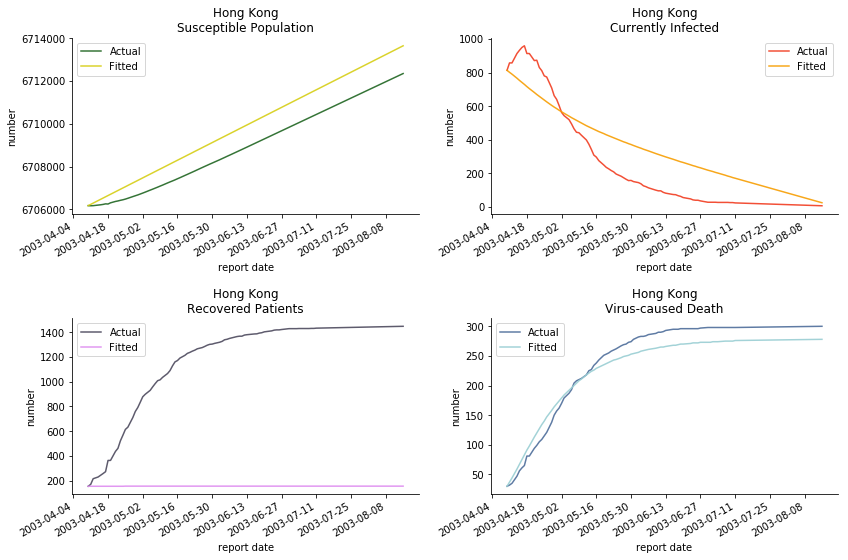

In [27]:
data=datahk.copy(deep=True)

if create_in_sample_output(diagnosis=True,
                           beta_guess=0.00007058,
                           delta_guess=1.3e-02,
                           epsilon_guess=0.000032):
    plot_all()
    data.to_csv('sars-hk-powerlaw-in-sample.csv')


Infection Rate: 0.000116615
Fatality Rate: 0.01255
Recovery Rate: 0.0


Basic Reproductive Ratio: 1.633837680755932



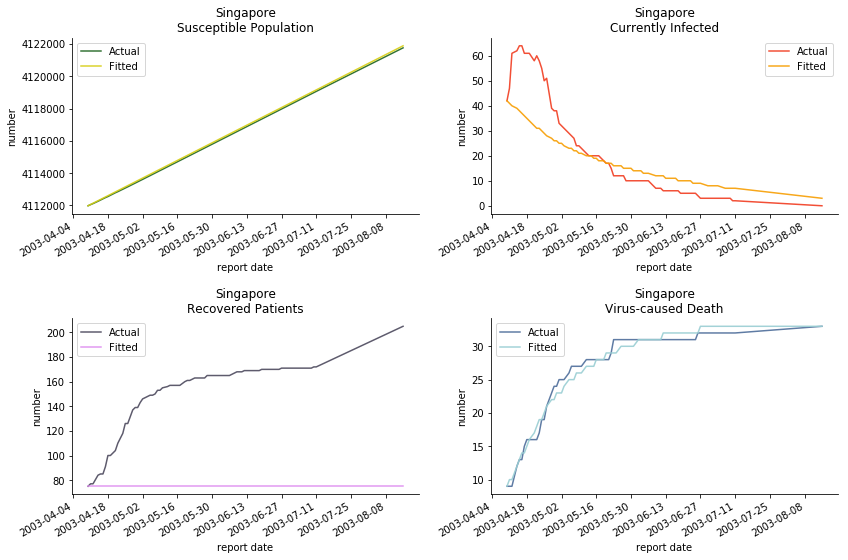

In [28]:
data=datasg.copy(deep=True)

if create_in_sample_output(diagnosis=True,
                           beta_guess=1.16615e-04,
                           delta_guess=0.01255,
                           epsilon_guess=0.000002):
    plot_all()
    data.to_csv('sars-sg-powerlaw-in-sample.csv')


Infection Rate: 7.777e-05
Fatality Rate: 0.00837
Recovery Rate: 0.0


Basic Reproductive Ratio: 1.6338158266696643



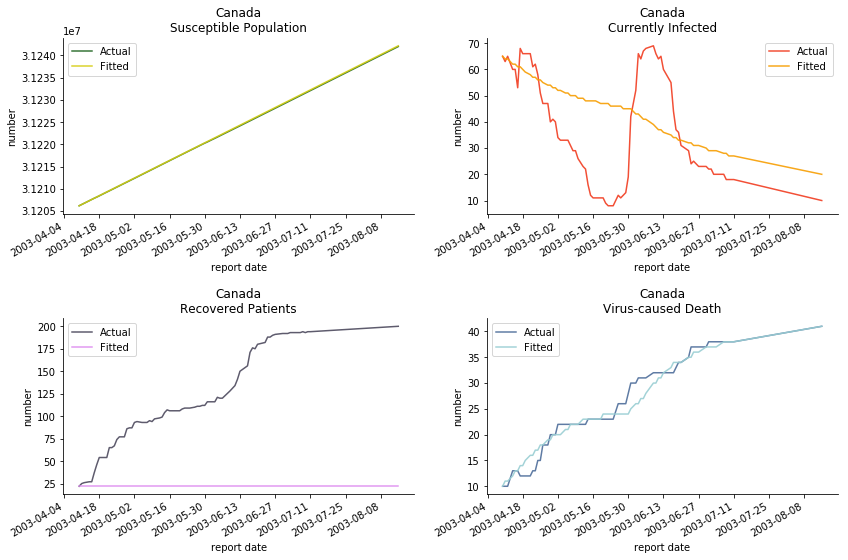

In [29]:
data=dataca.copy(deep=True)

if create_in_sample_output(beta_guess=0.7777e-04,
                           delta_guess=0.00837,
                           epsilon_guess=0.000001,
                           diagnosis=True):
    plot_all()
    data.to_csv('sars-ca-powerlaw-in-sample.csv')


Infection Rate: 9.85872e-05
Fatality Rate: 0.0
Recovery Rate: 0.01061


Basic Reproductive Ratio: 1.6338261758121722



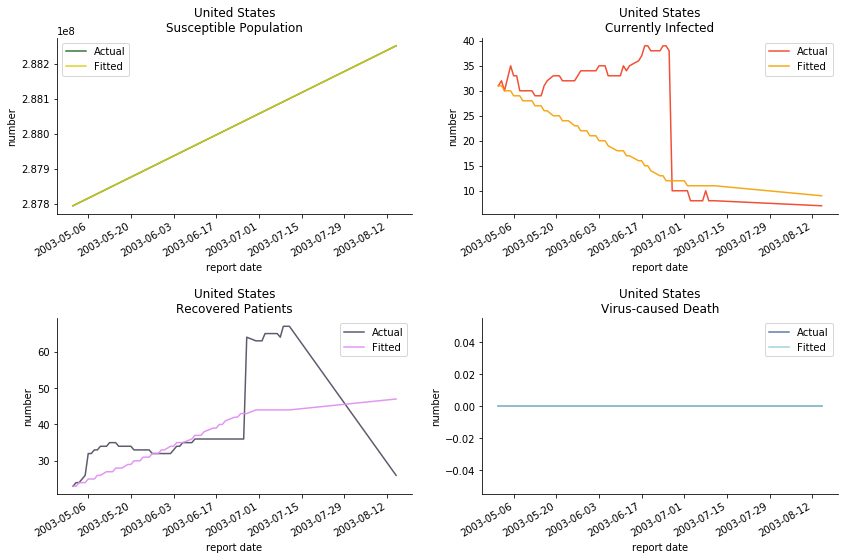

In [30]:
data=dataus.copy(deep=True)

if create_in_sample_output(diagnosis=True,
                           beta_guess=7.181303e-05,
                           delta_guess=1.16e-10,
                           epsilon_guess=0.03):
    plot_all()
    data.to_csv('sars-us-powerlaw-in-sample.csv')


Infection Rate: 0.0006877382
Fatality Rate: 0.00513
Recovery Rate: 0.0689


Basic Reproductive Ratio: 1.6338287602857653



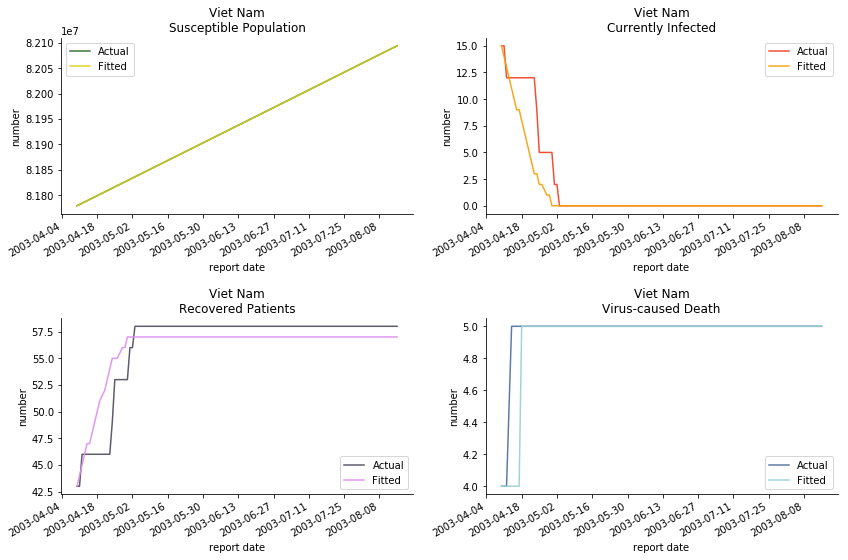

In [31]:
data=datavn.copy(deep=True)

if create_in_sample_output(beta_guess=6.631049e-04,
                           delta_guess=0.015,
                           epsilon_guess=0.04,
                           diagnosis=True):
    plot_all()
    data.to_csv('sars-vn-powerlaw-in-sample.csv')


Infection Rate: 0.0001243984
Fatality Rate: 0.01339
Recovery Rate: 0.0


Basic Reproductive Ratio: 1.6338231135305452



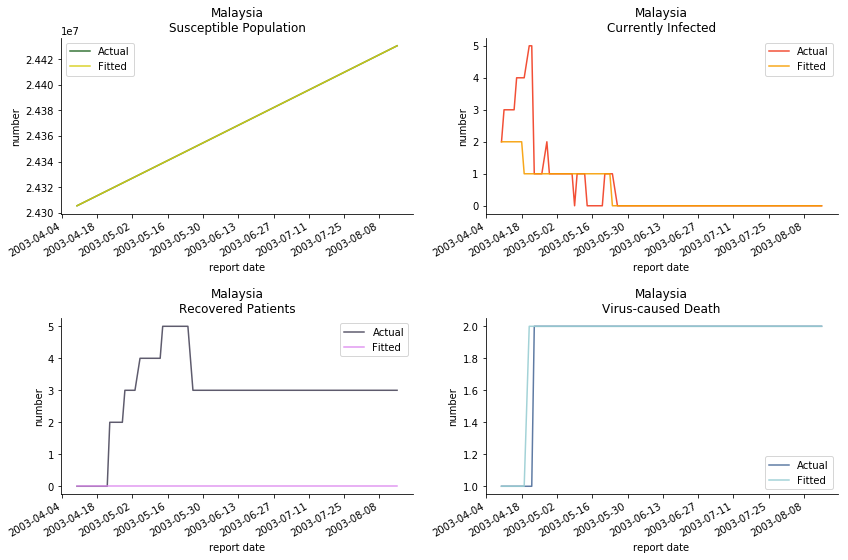

In [32]:
data=datamy.copy(deep=True)

if create_in_sample_output(diagnosis=True,
                           beta_guess=1.200177e-04,
                           delta_guess=0.02,
                           epsilon_guess=0.0000037):
    plot_all()
    data.to_csv('sars-my-powerlaw-in-sample.csv')


Infection Rate: 0.0003026851
Fatality Rate: 0.00583
Recovery Rate: 0.02675


Basic Reproductive Ratio: 1.6338256490008205



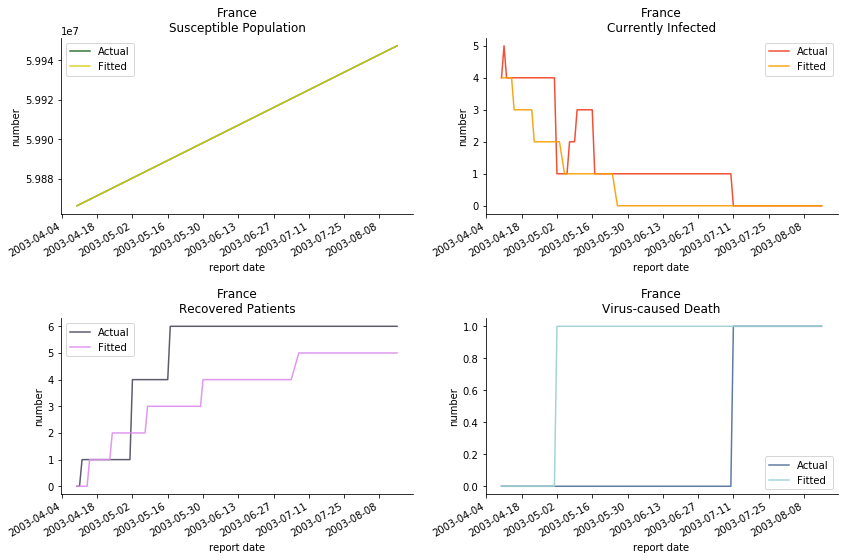

In [33]:
data=datafr.copy(deep=True)

if create_in_sample_output(diagnosis=True,
                           beta_guess=2.3611902e-04,
                           delta_guess=0.007,
                           epsilon_guess=0.03):
    plot_all()
    data.to_csv('sars-fr-powerlaw-in-sample.csv')

&nbsp;
### Out-of-sample Data
&nbsp;

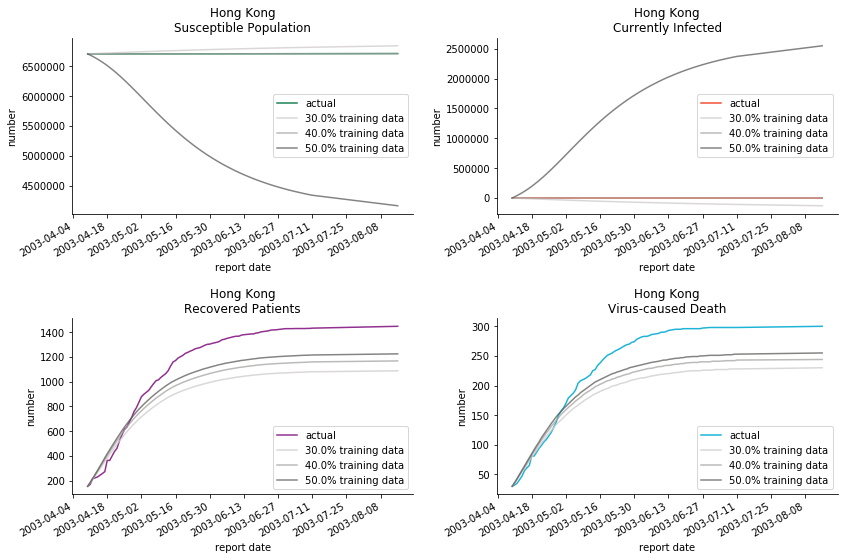

In [34]:
data=datahk.copy(deep=True)

create_outta_sample_output(train_init=[(0.005,1.3e-02,0.02)]*5)
data.to_csv('sars-hk-powerlaw-outta-sample.csv')

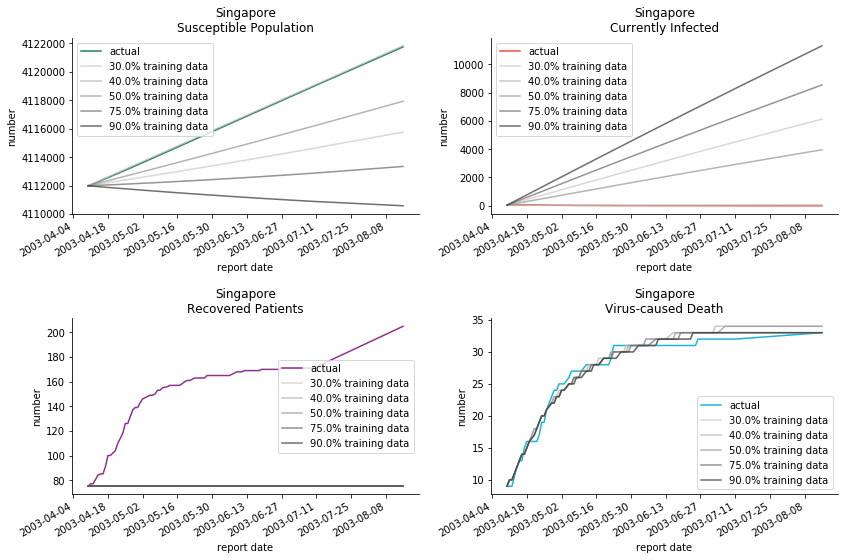

In [35]:
data=datasg.copy(deep=True)
create_outta_sample_output(train_init=[(1.2688e-04,0.01255,0.000002)]*5)
data.to_csv('sars-sg-powerlaw-outta-sample.csv')

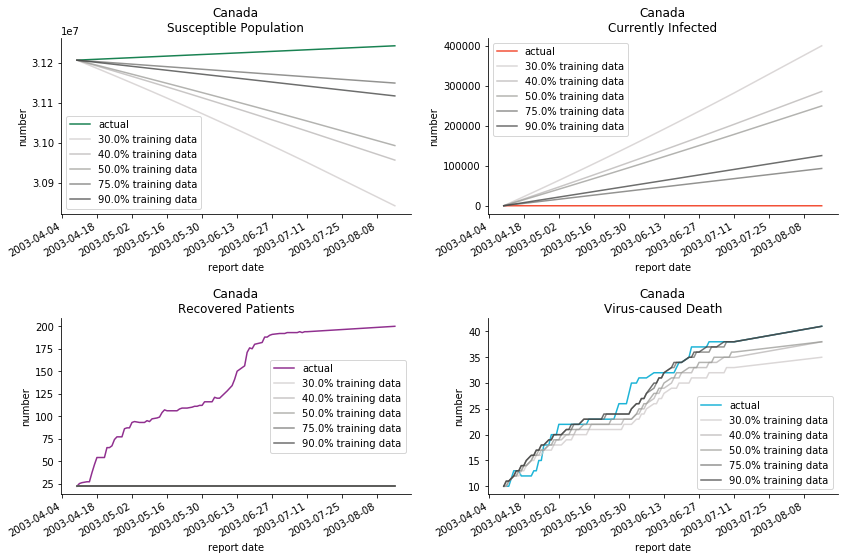

In [36]:
data=dataca.copy(deep=True)
create_outta_sample_output(train_init=[(0.88e-04,0.00837,0.000001)]*5)
data.to_csv('sars-ca-powerlaw-outta-sample.csv')

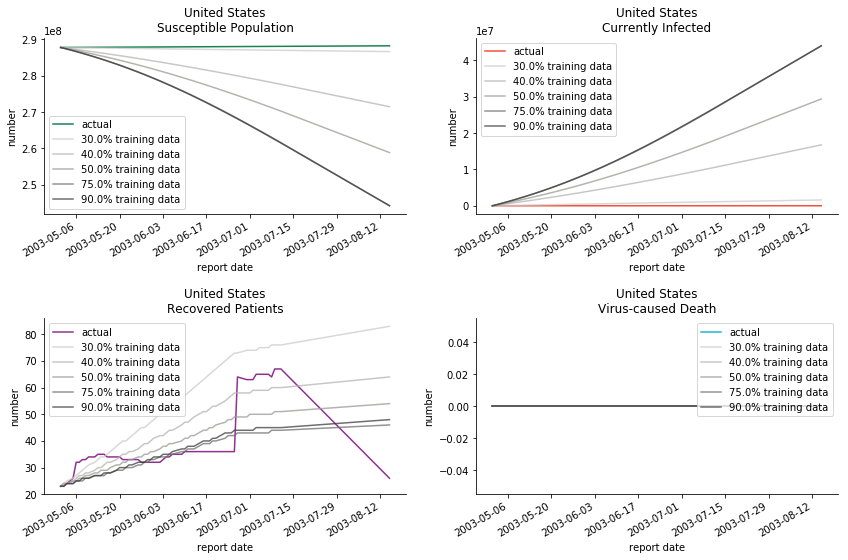

In [37]:
data=dataus.copy(deep=True)
create_outta_sample_output(train_init=[(2.4e-04,1.16e-10,0.03)]*5)
data.to_csv('sars-us-powerlaw-outta-sample.csv')

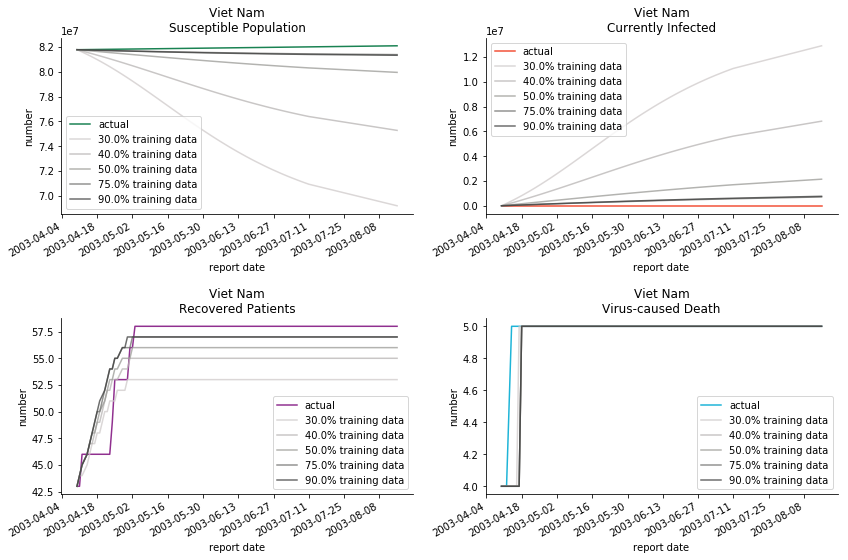

In [38]:
data=datavn.copy(deep=True)
create_outta_sample_output(train_init=[(6.63e-04,0.015,0.04)]*5)
data.to_csv('sars-vn-powerlaw-outta-sample.csv')

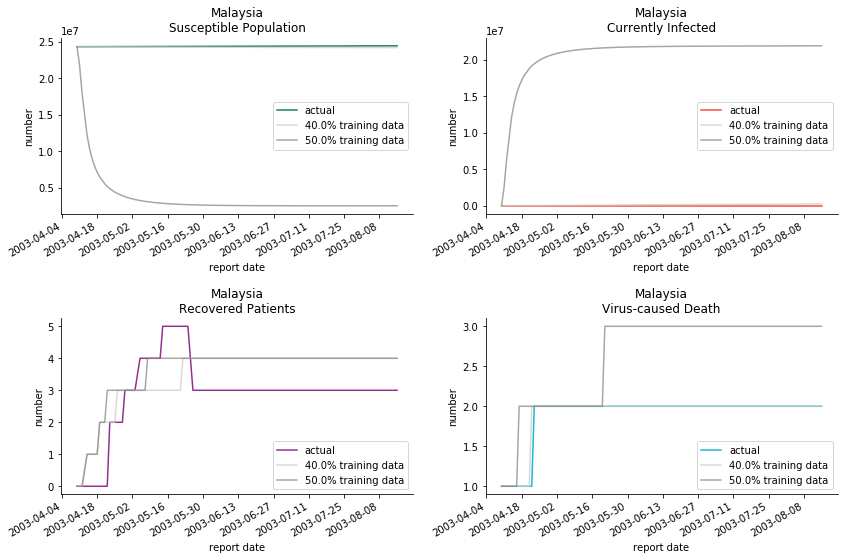

In [39]:
data=datamy.copy(deep=True)
create_outta_sample_output(train_init=[(8.72e-02,0.02,0.037)]*5)
data.to_csv('sars-my-powerlaw-outta-sample.csv')

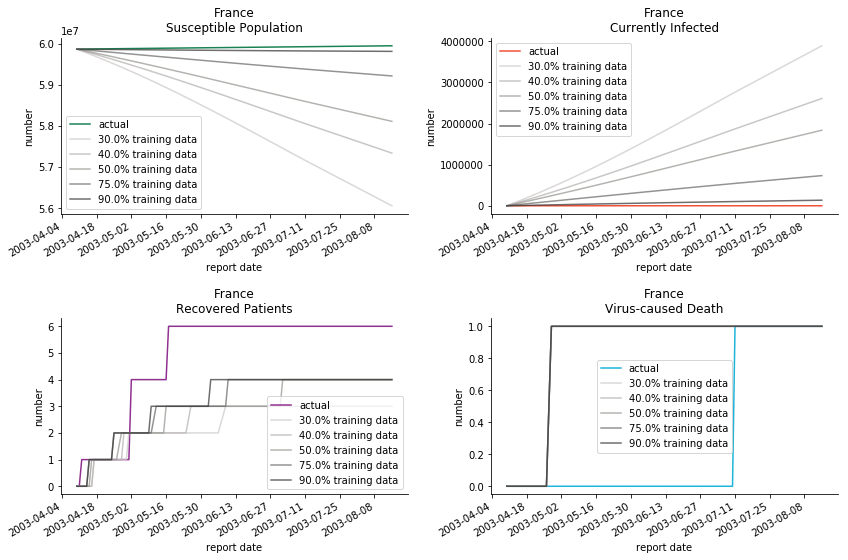

In [40]:
data=datafr.copy(deep=True)
create_outta_sample_output(train_init=[(2.9e-04,0.007,0.03)]*5)
data.to_csv('sars-fr-powerlaw-outta-sample.csv')